Comparing the GRB's :

`(361, [385, 420, 488])`

In [4]:
import pandas as pd
import numpy as np
import os
from astropy.io import fits
from dtw import dtw
from scipy.stats import poisson, norm
import time

import light_curve as lc
import estimate_source_angles_detectors as esad

In [5]:
import matplotlib.pyplot as plt

In [6]:

def brightest_detectors(ra, dec, grbnumbers):
    '''
    Function to find the name of the brightest NaI detector for a particular GRB

        params : ra = list of ra values 
        params : dec = list of dec values
        params : grbnumbers = list of numbers of grbs
        returns : list of brightest detectors
    '''
    detectors = []  # brightest detector name
    for i, number in enumerate(grbnumbers):
        dig = 0  # suffix digit _v00 or _v01 or v_02 ...
        path = ''
        while not os.path.exists(path):
            path = 'C:/Users/hhsud/Downloads/GRBS/glg_trigdat_all_bn' + number + '_v0' + str(dig) + '.fit'
            dig += 1
            if dig > 100:
                raise FileNotFoundError
        b = esad.angle_to_grb(ra[i], dec[i], path)
        detectors.append(b[0])
    
    return detectors

In [7]:

def _round(x):
    '''
    Function to round all elements of a list to 2 digits

        params : x = list of floats
        returns : list of floats
    '''
    return [round(a,2) for a in x]


In [8]:

def find_mean_std(simulated_curves, referenceLC):
    '''
    Function to find mean and sigma of DTW distribution given simulated curves
    and reference light curve

        params : simulated_curves = list of simulated curves
        params : referenceLC = list of ints of reference light curves
        returns : mean and standard deviation by normally approx. distance distribution
    '''
    distances = []
    for curve in simulated_curves:
        distances.append(lc.getDTW(referenceLC, curve))
    
    return norm.fit(distances), distances  # returns mean and stddev

In [9]:
def get_light_curve(grb, grbname, size = 0, show = False):
    '''
    function to plot histogram and get the photon counts/ light curve
    from the raw fitfile
    grb = fitfile of the GRB
    size = binsize ; default = 0 -> calculate binsize according to t90
    '''


    def binsize(t90):
        '''
        Function to return binsize according to T90
            params : t90 of grb
            returns : 0.1 if t90 < 2 else 1
        '''
        if t90 >= 2:
            return 1
        else:
            return 0.1


    # create the dataframe with time and ttime
    df = lc.df_from_fit_file(grb)

    # get t90
    t90 = lc.get_t90(grbname)

    # start, end 
    start, end = -10, t90 + 10

    # binsize
    if size == 0:
        size = binsize(t90)
        
    # plot hist and get count value        
    N = np.histogram(df.TTIME, bins=int( (end-start)/size), range=(start,end))
    
    return N[0]

In [10]:

def simulate(fitfile, grbname, num, size = 0):
    '''
    Function to simulate light curves with poisson distribution
        
        params : fitfile = GRB to simulate
        params : size = binsize of GRB
        params : num = number of simulated curves
        returns : simulated curves (list)
    '''

    reference = get_light_curve(fitfile, grbname, size)
    simcurves = []  # for simulated curves
    for _ in range(num):
        curve = []
        for n in reference:
            curve.append(poisson.rvs(mu = n, size = 1)[0])
        simcurves.append(curve)
    return simcurves

In [20]:
def distance_data(nbd_info):
    '''
    Function to take nbd array and append all related info to a dataframe

        params : nbd_info = neighborhood array with a center grb index and a list of nbd grbs
        returns : time taken to compare grbs 
    '''


    start_time = time.perf_counter()

    #-----get the ra and dec values of grbs to compare-----
    lcdf = pd.read_csv('data/gbmdatacleaned.csv', index_col=0)  # light curve data frame

    grb_index = nbd_info[1].copy()  # copy neighborhood indices list
    grb_index.insert(0, nbd_info[0])  # insert the center index at 0th pos

    # ra-dec, name of selected grbs
    ra = [] 
    dec = [] 
    grbnames = [] 
    for i in grb_index:
        ra.append(lcdf.iloc[i].ra_val)
        dec.append(lcdf.iloc[i].dec_val)
        grbnames.append(lcdf.name.iloc[i])
    
    ra = _round(ra)
    dec = _round(dec)

    grbnumbers = [x[3:] for x in grbnames] # GRB number
    grbt90 = [lc.get_t90(name) for name in grbnames] # t90's
    grbbinsize = [lc.binsize(t90) for t90 in grbt90] # bin sizes

    detectors = brightest_detectors(ra, dec, grbnumbers)
    
    #-----open the fits file corresponding to the brightest NaI detectors-----
    fitfiles = []
    for detector, number in zip(detectors, grbnumbers):
        # try suffix _v01 or _v00
        dig = 0
        path = ''
        while not os.path.exists(path):
            path = 'C:/Users/hhsud/Downloads/GRBS/glg_tte_' + detector + '_bn' + number + '_v0' + str(dig) + '.fit'
            dig += 1
            if dig > 100:
                print(path)
                raise FileNotFoundError
        
        fitfile = fits.open(path)
        fitfiles.append(fitfile)

    #-----make DTW distane list-----
    ref_name = grbnames[0]
    referenceLC = get_light_curve(fitfiles[0], ref_name) # reference fit file
    distance_list = [] # for DTW distances
    for fitfile, tar_name in zip(fitfiles, grbnames): 
        targetLC = get_light_curve(fitfile, tar_name) # target fit file
        d = lc.getDTW(referenceLC, targetLC, ref_name, tar_name) # get DTW distance
        distance_list.append(round(d,3))


    #-----simulate the light curves-----
    simulated_curves_big = simulate(fitfiles[0], ref_name, 1000)  # simulation with binsize 1
    (mu_big, sigma_big), sim_distances = find_mean_std(simulated_curves_big, referenceLC)
    
    if 0.1 in grbbinsize:
        simulated_curves_small = simulate(fitfiles[0], ref_name, 100, 0.1)
        mu_small, sigma_small = find_mean_std(simulated_curves_small, referenceLC)


    # number of stdev away from mean
    stddev = []
    for size, d in zip(grbbinsize, distance_list):
        # if binsize is 0.1
        if size == 0.1:
            delta = round((d - mu_small)/sigma_small,3)
        else:
            delta = round((d - mu_big)/sigma_big,3)
        stddev.append(abs(delta))
            
    stddev[0] = None # sigma value for ref grb compared to itself
    
    isref = [1] + [0] * (len(grbnames) - 1) # boolean array ; 1 if GRB is a reference GRB
    # datadf1 = pd.read_csv('data/distance_dat_file.csv')
    datadf = pd.DataFrame({'Index':grb_index, 'Is Reference': isref, 'Name':grbnames,
                           'Brightest Detector':detectors, 'ra': ra, 'dec':dec,
                           't90':grbt90, 'Binsize':grbbinsize, 'Distance':distance_list,
                           'Sigma':stddev})

    print(datadf)

    end_time = time.perf_counter()
    delta_time = end_time - start_time
    print(f'Time = {delta_time:.2f}')
    return datadf, mu_big, sigma_big, sim_distances

   Index  Is Reference          Name Brightest Detector      ra    dec  \
0    361             1  GRB160827586                 n4  155.16 -55.91   
1    385             0  GRB190830264                 n2  159.20 -54.71   
2    420             0  GRB150422294                 n9  156.02 -53.56   
3    488             0  GRB101227536                 n7  150.87 -49.44   

      t90  Binsize  Distance   Sigma  
0  51.200        1       0.0     NaN  
1   5.376        1    2775.0   6.796  
2  30.208        1    1460.0   1.483  
3  28.864        1    3461.0  11.115  
Time = 15.54


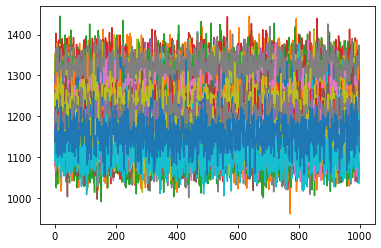

In [12]:
grbdf, mu, sigma, sim_distances = distance_data((361, [385, 420, 488]))

In [13]:
def make_hist(ref, ref_name, tar, tar_name, info_tuple):
    # get raw fit files
    df_ref = lc.df_from_fit_file(ref)
    df_tar = lc.df_from_fit_file(tar)

    # get t90s
    t90_ref = lc.get_t90(ref_name)
    t90_tar = lc.get_t90(tar_name)

    # xmin of plot
    start1 = -10
    # xmax of plot
    end1 = max(t90_ref, t90_tar) + 10

    # binsizes
    size1 = 0.1 if t90_ref < 2 else 1
    size2 = 0.1 if t90_tar < 2 else 1
    
    # plotting
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
    fig.suptitle(f'Distance : {info_tuple[0]}, Sigma : {info_tuple[1]}', fontsize=16)
    # plot reference curve
    ref = axs[0].hist(df_ref.TTIME, bins=int((end1 - start1)/size1), range=(start1,end1),
                label = ref_name, histtype='step', color='b')
    # plot target curve
    tar = axs[1].hist(df_tar.TTIME, bins=int((end1 - start1)/size2), range=(start1,end1),
                label = tar_name, histtype='step', color='g')
    
    # remove the front patch
    ref[2][0].set_xy(ref[2][0].get_xy()[1:])
    tar[2][0].set_xy(tar[2][0].get_xy()[1:])
    # remove the end patch
    ref[2][0].set_xy(ref[2][0].get_xy()[:-1])
    tar[2][0].set_xy(tar[2][0].get_xy()[:-1])
    
    # have apt space between the plots
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0)
    # legend position 
    fig.legend(bbox_to_anchor=(0.4,0.6), borderaxespad=0, labels=[ref_name, tar_name], loc='center right')

In [14]:
def get_fit_file(name):
    d = grbdf.loc[grbdf['Name'] == name]['Brightest Detector'].values[0]
    # try suffix _v01 or _v00
    dig = 0
    path = ''
    while not os.path.exists(path):
        path = 'C:/Users/hhsud/Downloads/GRBS/glg_tte_' + d + '_bn' + name[3:] + '_v0' + str(dig) + '.fit'
        dig += 1
        if dig > 100:
            print(path)
            raise FileNotFoundError

    return fits.open(path)

In [15]:
dct = {361 : [385, 420, 488]}

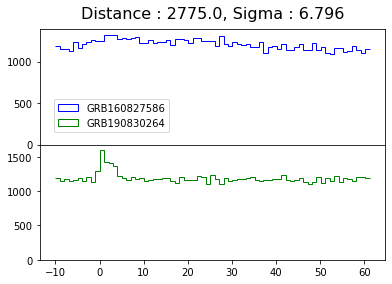

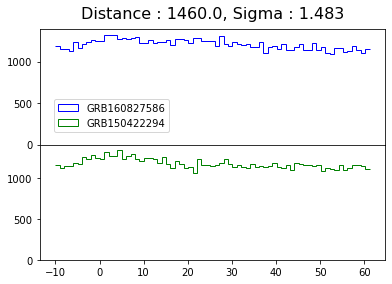

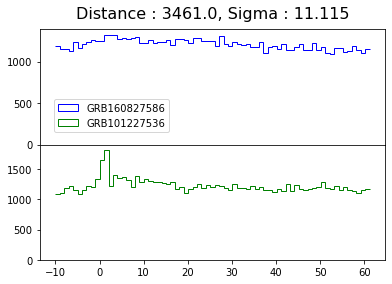

In [16]:
for i, (key, value) in enumerate(dct.items()):
    ref_name = grbdf[grbdf.Index == key]['Name'].values[0]
    ref = get_fit_file(ref_name)
    for x in value:
        tar_name = grbdf[grbdf.Index == x]['Name'].values[0]
        tar = get_fit_file(tar_name)
        row = grbdf.loc[grbdf.Index == x]
        info_tuple = (row.Distance.values[0], row.Sigma.values[0])
        make_hist(ref, ref_name, tar, tar_name, info_tuple)

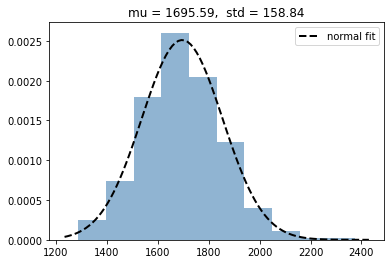

In [17]:
# Plot the histogram.
plt.hist(sim_distances, density=True, alpha=0.6, color='steelblue')

# Plot normal fit.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, '--k', linewidth=2, label='normal fit')
plt.title(f"mu = {mu:.2f},  std = {sigma:.2f}")
plt.legend()

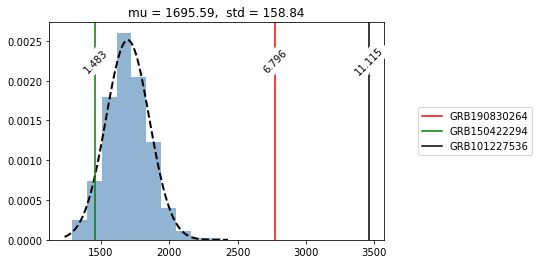

In [18]:
from scipy.stats import norm

# Plot the histogram.
plt.hist(sim_distances, density=True, alpha=0.6, color='steelblue')

# Plot normal fit.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, '--k', linewidth=2)
plt.title(f"mu = {mu:.2f},  std = {sigma:.2f}")

# Plot distance vertical lines
colors = ['b', 'r', 'g', 'k']
for index, row in grbdf.iterrows():
    if row.Distance:
        plt.axvline(row.Distance, color=colors[index], label=row.Name)
        plt.text(row.Distance, 0.00225, row.Sigma , ha='center', va='center',rotation='45', backgroundcolor='white')
        
# Adjust legend 
plt.legend(bbox_to_anchor=(1.1,0.5), borderaxespad=0, loc='center left')
plt.show()

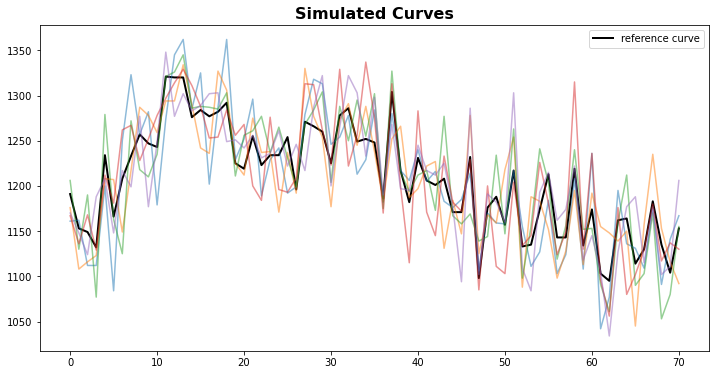

In [19]:
name = 'GRB160827586'
fitfile = get_fit_file(name)
ref_curve = get_light_curve(fitfile, name)
sim_curves = simulate(fitfile, name, 5)
plt.figure(figsize=(12,6))
plt.plot(ref_curve, 'k', linewidth=2, label='reference curve')
for y in sim_curves:
    plt.plot(y, alpha=0.5)
plt.title('Simulated Curves', fontweight='bold', fontsize=16)
plt.legend()

In [31]:
with open('file.txt', 'w') as f:
    f.write(grbdf.to_latex())

C:\Users\hhsud\AppData\Local\Temp\ipykernel_17856\2089307787.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(grbdf.to_latex())


In [30]:
grbdf.to_latex()

C:\Users\hhsud\AppData\Local\Temp\ipykernel_17856\3815543379.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  grbdf.to_latex()


'\\begin{tabular}{lrrllrrrrrr}\n\\toprule\n{} &  Index &  Is Reference &          Name & Brightest Detector &      ra &    dec &     t90 &  Binsize &  Distance &   Sigma \\\\\n\\midrule\n0 &    361 &             1 &  GRB160827586 &                 n4 &  155.16 & -55.91 &  51.200 &        1 &       0.0 &     NaN \\\\\n1 &    385 &             0 &  GRB190830264 &                 n2 &  159.20 & -54.71 &   5.376 &        1 &    2775.0 &   6.796 \\\\\n2 &    420 &             0 &  GRB150422294 &                 n9 &  156.02 & -53.56 &  30.208 &        1 &    1460.0 &   1.483 \\\\\n3 &    488 &             0 &  GRB101227536 &                 n7 &  150.87 & -49.44 &  28.864 &        1 &    3461.0 &  11.115 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
df1